# Fitting a one-dimensional cross spectrum

This notebook covers how to fit in nDspec one of the most common spectral timing products: a one dimensional cross spectrum, as a function of Fourier frequency, between two energy bands. For least-chi squares fitting, nDspec makes use of the [lmfit library](https://lmfit.github.io/lmfit-py/). For error estimation, we encourage users to use Bayesian sampling, as detailed in the tutorial on [fitting power spectra](https://ndspec.readthedocs.io/en/simplefit_0.1/fit_psd.html).

In [1]:
import os
import sys
import numpy as np

sys.path.append('/home/matteo/Software/nDspec/src/')
from ndspec.Response import ResponseMatrix
import ndspec.FitCrossSpectrum as fitcross
import ndspec.models as models
from ndspec.SimpleFit import load_lc

## Setting up the data with Stingray

There are two methods of loading a frequency-dependent cross spectrum in nDspec. Users can either provide a Stingray `EventList` object, containing a level-2 event file, or they can provide their own cross spectrum and its errors, along with the corresponding Fourier frequency grid, in the form of a Numpy array. In this notebook, we will use the former method. Because the cross-spectrum is inherently an energy-dependent product, users must also supply an appropriate `ResponseMatrix` object. 

We begin by loading an event file and removing bad time intervals from it (for more details, see the [Stingray documentation page](https://docs.stingray.science/en/stable/notebooks/Spectral%20Timing/Spectral%20Timing%20Exploration.html#Data-loading-and-cleanup.)). We then loand and store the NICER response for this observation.

In [2]:
from stingray import EventList
from stingray.gti import get_gti_lengths, get_btis, get_total_gti_length

obsid = str(106)
path = "/home/matteo/Data/J1820/EventFiles/"
fname = path + "ni1200120" + obsid+ "_0mpu7_cl.evt"
events = EventList.read(fname, "hea", additional_columns=["DET_ID"])

gti_lengths = get_gti_lengths(events.gti)
btis = get_btis(events.gti)
bti_lengths = get_gti_lengths(btis)

ev_filled = events.fill_bad_time_intervals(max_length=1, buffer_size=4)

rmfpath = path+"1200120106_rmf.pha"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = path+"1200120106_arf.pha"
nicer_matrix.load_arf(arfpath)

Arf missing, please load it
Arf loaded


After loading the data and response, we can set up our fitter object. Because a cross spectrum is more complicated than a time-averaged or power spectrum, we need to specify several more quantities.

First, after initializing our fitter object `FitCrossSpectrum`, we need to set the coordinates that we will use for the complex cross spectra both in the model and data. Users can do this with the `set_coordinates` method, which selects between polar coordinates (modulus and phase), cartesian coordinates (real and imaginary parts), or lags (phase alone, converted into a time lag). Additionally, we need to specify whether we will use frequency or energy dependent products - for example, lag-frequency or lag-energy spectra. In this notebook we will focus on frequency dependent products. Users can do this with the `set_product_dependence` method.

Having set up the fitter object, we then need to define the information required to convert our loaded event file into cross spectra. We need to define reference and subject bands (here, 0.5-1.5 and 2-5 keV respectively), the size of the segments to average over (which will set the lowest Fourier frequency bin), the time resolution to use (which will set the highest Fourier frequency bin), and the normalization to use for the data. The `set_data` then converts the provided `EventList` object internally into a Poisson-noise subtracted cross spectrum, based on these inputs. For more information on calculating a cross spectrum, we refer users to [Uttley et al. 2014](https://ui.adsabs.harvard.edu/abs/2014A%26ARv..22...72U/abstract). 

After loading the data, we can plot it with the `plot_data_1d` method. 

/home/matteo/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/matteo/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/matteo/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2991: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


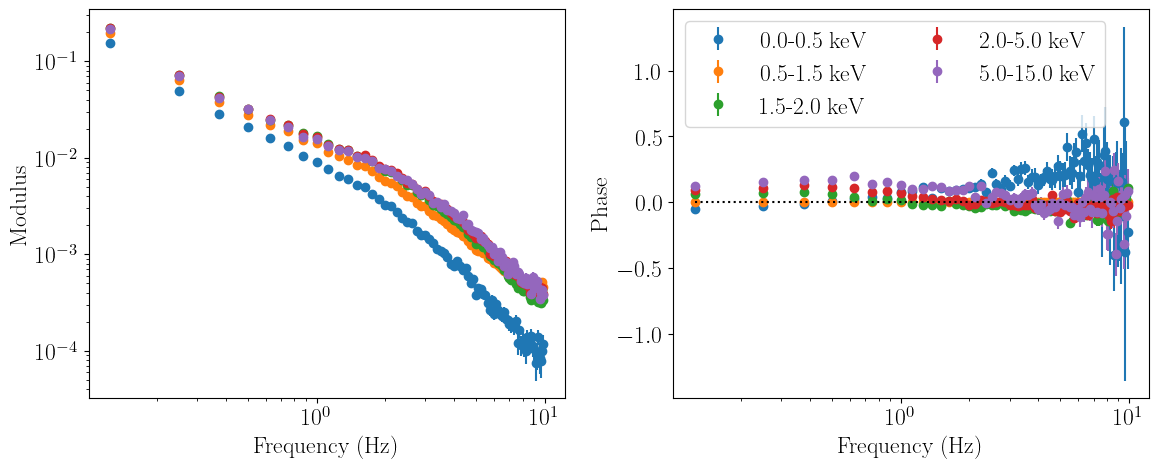

In [3]:
lorentz_fit = fitcross.FitCrossSpectrum()
lorentz_fit.set_coordinates("polar")
lorentz_fit.set_product_dependence("frequency")

ref_band = [0.5,1.5]
sub_band = [2.,5.]
segment_size = 8
dt = 0.05
norm_data = "frac"

lorentz_fit.set_data(nicer_matrix,ref_band,sub_band,events,
                     time_res=dt,seg_size=segment_size,norm=norm_data)  

lorentz_fit.plot_data_1d()

Note that we don't have a one-dimensional cross spectrum yet - in fact, the data is binned in four or five channels: the reference band (0.5-1.5 keV), the subject band (2-5 keV), the channels between reference and subject bands (1.5-2 keV), and finally the channels from whichever is lowest/highest among the subject/reference band bounds and the start/end of the response matrix (0-0.5 keV and 5-15 keV respectively). 

For our one-dimensional analysis we are clearly not interested in these additional channels (or in the reference band channels), so we must set them to be ignored identically to how one would ignore energy bins in a time-averaged spectrum. Therefore, we ignore all the data except that contained in the subject band channels. Once we plot the data again, we see that the only channel left is the subject band we are interested in.

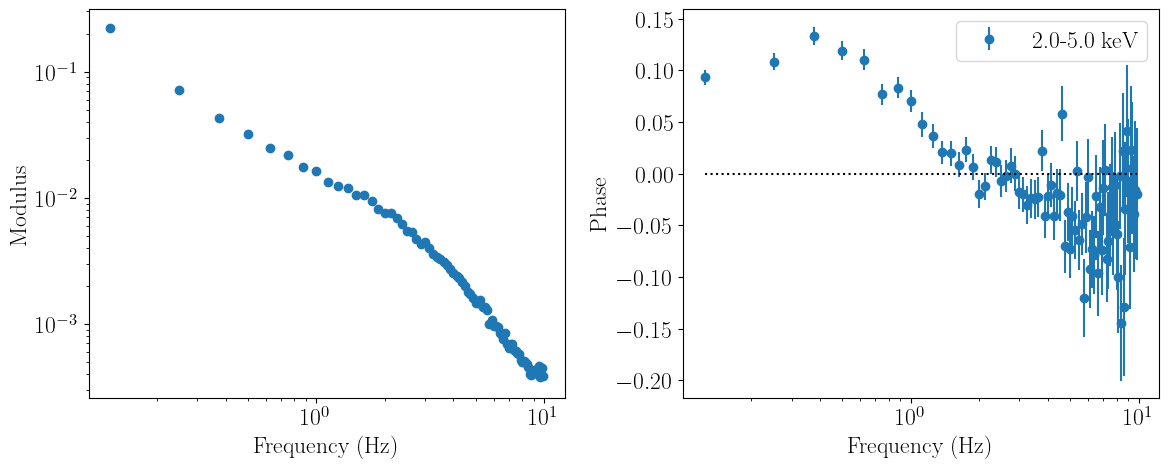

In [4]:
lorentz_fit.ignore_energies(0,2.0)
lorentz_fit.ignore_energies(5.0,20.0)
lorentz_fit.plot_data_1d()

An important note is that in this particular fit, nDspec automatically rebins the instrument response to match the channel grid specified in creating our cross spectrum. In this case, the response is rebinned down to just the five channels discussed above. This greatly speeds up folding the response matrix with our chosen model.

/home/matteo/Software/nDspec/src/ndspec/Response.py:526: RuntimeWarning: divide by zero encountered in log10
  p = plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


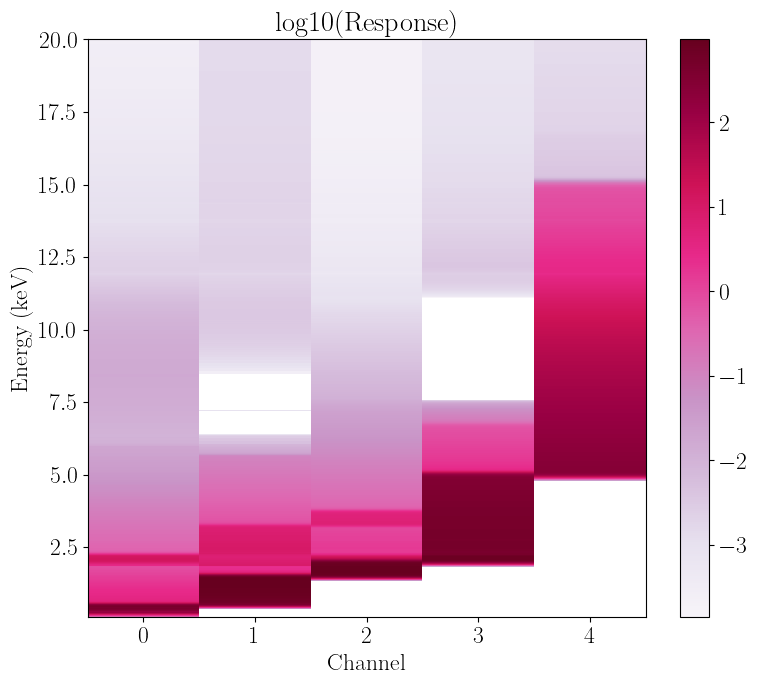

In [5]:
lorentz_fit.response.plot_response()

Finally, loading data in cartesian rather than polar coordinates is identical. We simply specify the coordinates differently when setting up the fitter object; everything else (including model calcluations to return the correct products) is handled internally by the fitter class:

/home/matteo/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/matteo/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/matteo/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2991: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(
/home/matteo/Software/nDspec/src/ndspec/FitCrossSpectrum.py:513: RuntimeWarning: invalid value encountered in sqrt
  error_second_dim = np.sqrt((ps_sub.power*ps_ref.power- \


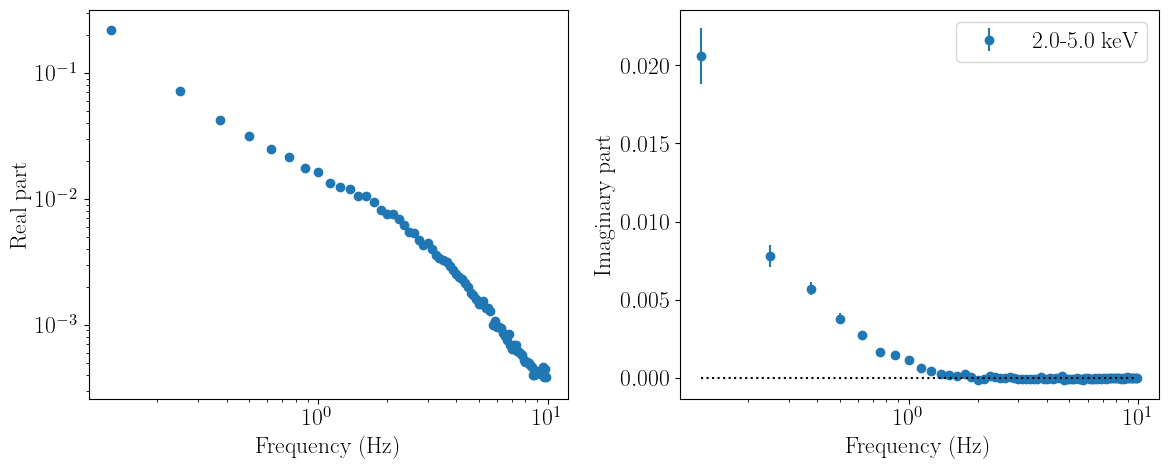

In [6]:
cartesian_coords = fitcross.FitCrossSpectrum()
cartesian_coords.set_coordinates("cartesian")
cartesian_coords.set_product_dependence("frequency")

ref_band = [0.5,1.5]
sub_band = [2.,5.]

cartesian_coords.set_data(nicer_matrix,ref_band,sub_band,events,
                     time_res=dt,seg_size=segment_size,norm="frac")  

cartesian_coords.ignore_energies(0,2.0)
cartesian_coords.ignore_energies(5.0,20.0)
cartesian_coords.plot_data_1d()

## Defining a model for the cross spectrum and preparing a fit

Now that the data is loaded, we can define a model for the complex cross spectrum itself. nDspec then handles the conversion from a complex cross spectrum, to any (real) spectral timing products (such as phase or modulus vs frequency) internally, depending on the data coordinates and dependence specified by the user.

In this example, we will use the model model of [Mendez et al. 2023](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.9405M/abstract): a sum of multiple Lorentzians, similar to standard fits of a powerspectrum, modifying each Lorentzian by a phase to introduce an imaginary component. This model is included in the nDspec model library, but we will re-define it here for clarity. 

For this particular observation, we will use a sum of six Lorentzian components. We instatiate an lmfit `Model` object, and assign the sum of Lorentzians to it. Then, we create an lmfit `Parameters` object to store the parameters of each Lorentzian. In this particular problem, we also have to ensure that the bounds of the Fourier frequency covered by each Lorentzian do not overlap, in order to simplify the parameter space and speed up the fit. 

Once both the `Model` and `Paramters` obejct are defined, we can pass them to our `FitCrossSpectrum` object. When passing the model, we also must specify what kind of model we are using - in this case, one that return a complex cross spectrum. This is necessary to ensure that the conversion from complex cross spectrum to modulus/phase as a function of frequency is handled correctly. nDspec also supports models for impulse response and transfer functions, but these are covered elsewhere TBD.

In [7]:
from lmfit import Model as LM_Model
from lmfit import Parameters as LM_Parameters

def cross_lorentz(energs,freqs,rms,peak_f,q,phase):
    n_energs = len(energs)
    n_freqs = len(freqs)
    lorentz_params = np.array([peak_f,q,rms])
    #calculate a standard Lorentzian, and include the phase term
    lorentz_arr = models.lorentz(freqs,lorentz_params)*np.exp(1j*phase)
    #reshape the model into an array of Fourier frequency times energy channels
    twod_lorentz = np.tile(lorentz_arr,n_energs).reshape((n_energs,n_freqs))
    twod_lorentz = np.transpose(twod_lorentz)
    return twod_lorentz

CrossLor_model = LM_Model(cross_lorentz, prefix="l1_") + \
                 LM_Model(cross_lorentz, prefix="l2_") + \
                 LM_Model(cross_lorentz, prefix="l3_") + \
                 LM_Model(cross_lorentz, prefix="l4_") + \
                 LM_Model(cross_lorentz, prefix="l5_")+ \
                 LM_Model(cross_lorentz, prefix="l6_")

Cross_model_parameters = LM_Parameters()
Cross_model_parameters.add_many(('l1_peak_f', 0.05, True, 0, 0.07),
                                ('l1_q', 0.3, True, 0, 2),
                                ('l1_rms', 0.008, True),
                                ('l1_phase', 0.1, True,-np.pi,+np.pi),
                                
                                ('l2_peak_f', 0.3, True, 0.07, 0.5),
                                ('l2_q', 0.5, True, 0, 2),
                                ('l2_rms', 0.003, True),
                                ('l2_phase', 0.3, True,-np.pi,+np.pi),
                                  
                                ('l3_peak_f', 1., True, 0.5, 1.5),
                                ('l3_q', 0.7, True, 0, 2),
                                ('l3_rms', 0.002, True),
                                ('l3_phase', 0.1, True,-np.pi,+np.pi),

                                ('l4_peak_f', 2, True, 1.5, 3),
                                ('l4_q', 0.2, True, 0, 2),
                                ('l4_rms', 0.005, True),
                                ('l4_phase', 0, True,-np.pi,+np.pi),
                                
                                ('l5_peak_f', 5, True, 3, 10),
                                ('l5_q', 1, True, 0, 2),
                                ('l5_rms', 0.003, True),
                                ('l5_phase', -0.13, True,-np.pi,+np.pi),

                                ('l6_peak_f', 15, True, 10, 30),
                                ('l6_q', 1.0, True, 0, 8),
                                ('l6_rms', 0.001, True),
                                ('l6_phase', -0.5, True,-np.pi,+np.pi) )

lorentz_fit.set_model(CrossLor_model,model_type="cross")
lorentz_fit.set_params(Cross_model_parameters)

 - Adding parameter "l1_freqs"
 - Adding parameter "l1_rms"
 - Adding parameter "l1_peak_f"
 - Adding parameter "l1_q"
 - Adding parameter "l1_phase"
 - Adding parameter "l2_freqs"
 - Adding parameter "l2_rms"
 - Adding parameter "l2_peak_f"
 - Adding parameter "l2_q"
 - Adding parameter "l2_phase"
 - Adding parameter "l3_freqs"
 - Adding parameter "l3_rms"
 - Adding parameter "l3_peak_f"
 - Adding parameter "l3_q"
 - Adding parameter "l3_phase"
 - Adding parameter "l4_freqs"
 - Adding parameter "l4_rms"
 - Adding parameter "l4_peak_f"
 - Adding parameter "l4_q"
 - Adding parameter "l4_phase"
 - Adding parameter "l5_freqs"
 - Adding parameter "l5_rms"
 - Adding parameter "l5_peak_f"
 - Adding parameter "l5_q"
 - Adding parameter "l5_phase"
 - Adding parameter "l6_freqs"
 - Adding parameter "l6_rms"
 - Adding parameter "l6_peak_f"
 - Adding parameter "l6_q"
 - Adding parameter "l6_phase"


Having set up our model, initialized the parameters, and passd it in our fitter obejct, we can evaluate the model and print the parameter values and intervals, and fit statistic, by calling the methods `model_params.pretty_print` and `print_fit_stat`. Finally, we can directly plot model and residuals against the data with the `plot_model_1d` method.

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
l1_peak_f      0.05        0     0.07     None     True     None     None
l1_phase        0.1   -3.142    3.142     None     True     None     None
l1_q            0.3        0        2     None     True     None     None
l1_rms        0.008     -inf      inf     None     True     None     None
l2_peak_f       0.3     0.07      0.5     None     True     None     None
l2_phase        0.3   -3.142    3.142     None     True     None     None
l2_q            0.5        0        2     None     True     None     None
l2_rms        0.003     -inf      inf     None     True     None     None
l3_peak_f         1      0.5      1.5     None     True     None     None
l3_phase        0.1   -3.142    3.142     None     True     None     None
l3_q            0.7        0        2     None     True     None     None
l3_rms        0.002     -inf      inf     None     True     None     None
l4_peak_f         2      1.5        

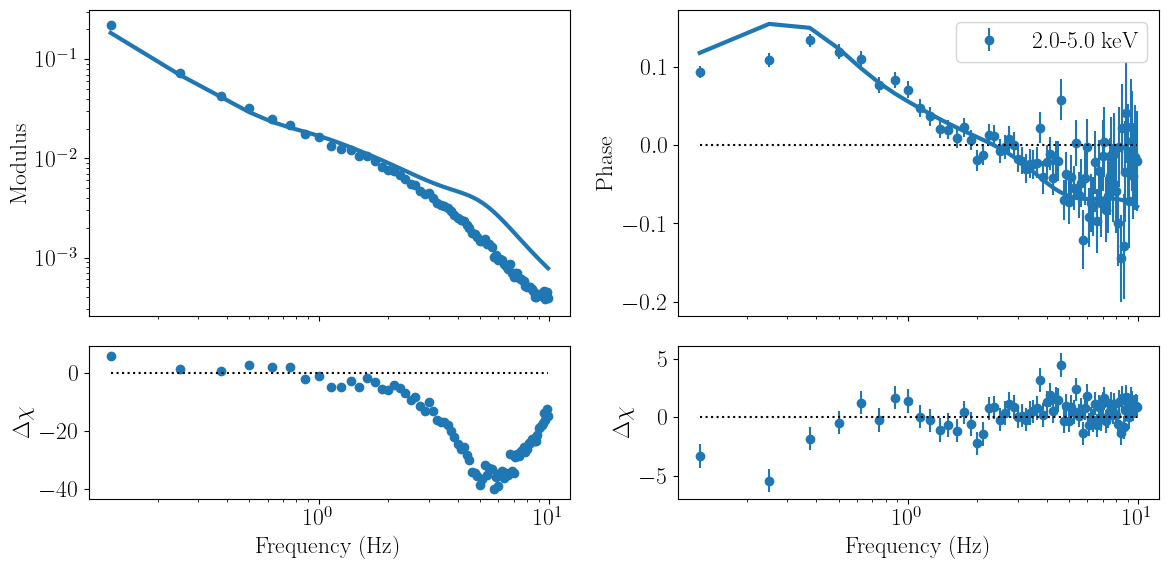

In [8]:
lorentz_fit.model_params.pretty_print()
lorentz_fit.print_fit_stat()
lorentz_fit.plot_model_1d()

## Running a fit

Having st up the data and model, we can now fit the data by minimizing the least-chi squared statistic with the `fit_data` method. Once the fit is complete, nDspec outputs the best-fit statistics, as well as the values of each parameters. 

We caution users that the uncertainty ranges reported this way are highly unreliable, and should never be used for publication in peer-reviewed journals. Instead, they should be seen as a rough indication of how constrained each parameter may or may not be. For calculating the credible intervals of each parameter, we encourage users to carefully perform Bayesian inference of each posterior distribution, which is discussed in the [nDspec notebook on fitting power spectra](https://ndspec.readthedocs.io/en/simplefit_0.1/fit_psd.html)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4094
    # data points      = 158
    # variables        = 24
    chi-square         = 158.800148
    reduced chi-square = 1.18507573
    Akaike info crit   = 48.7981289
    Bayesian info crit = 122.300410
[[Variables]]
    l1_peak_f:  0.07000000 +/- 0.57404983 (820.07%) (init = 0.05)
    l1_q:       0.14961968 +/- 3.18061607 (2125.80%) (init = 0.3)
    l1_rms:     0.00812024 +/- 0.02880438 (354.72%) (init = 0.008)
    l1_phase:   0.09092209 +/- 0.01110042 (12.21%) (init = 0.1)
    l2_peak_f:  0.40999309 +/- 0.06196409 (15.11%) (init = 0.3)
    l2_q:       0.89707033 +/- 0.70684625 (78.79%) (init = 0.5)
    l2_rms:     0.00182097 +/- 0.00254975 (140.02%) (init = 0.003)
    l2_phase:   0.33573865 +/- 0.68287920 (203.40%) (init = 0.3)
    l3_peak_f:  0.76169892 +/- 0.09847159 (12.93%) (init = 1)
    l3_q:       0.84474067 +/- 0.54841899 (64.92%) (init = 0.7)
    l3_rms:     0.00240004 +/- 0.00189868 (79.11%) (in

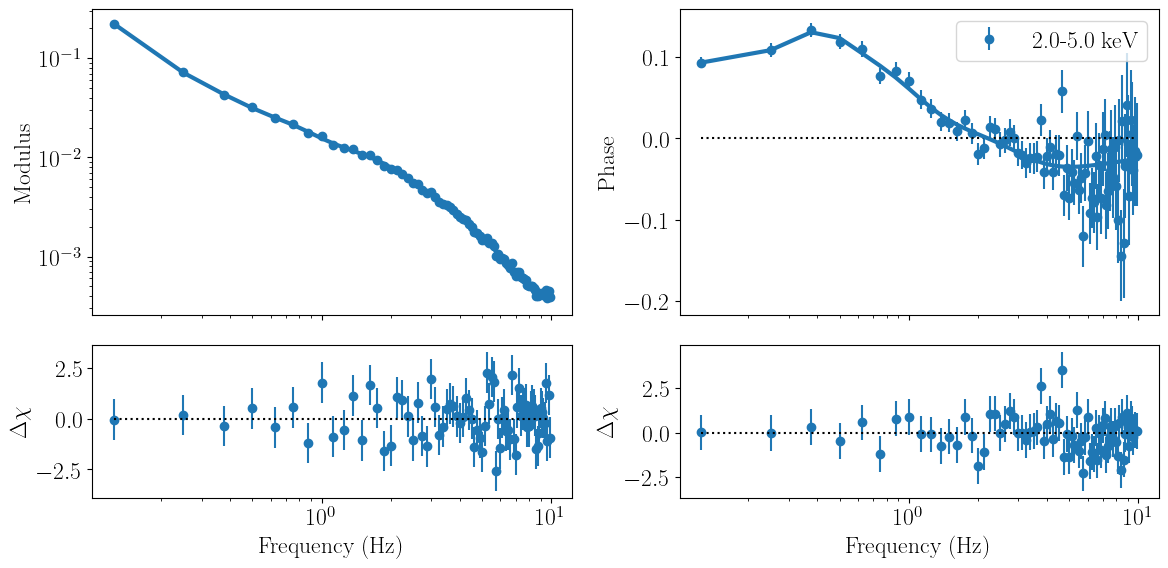

In [9]:
lorentz_fit.fit_data()
lorentz_fit.plot_model_1d()